# GHCN Weather Station Analysis

In this notebook I will work with the Global Historical Climatology Network (GHCN) dataset stored in Azure.  
The goal is to show the full data pipeline and analysis steps, including:

- **Ingestion and ETL**: Use Synapse Studio to read the raw CSV data, create external tables, and export it into Parquet format for efficient querying.  
- **Exploration**: Run SQL queries in Synapse to check counts, elements, and date ranges, and verify that the processed Parquet table contains the expected results.  
- **Analysis (Station 1)**: Connect a Jupyter notebook to the Synapse serverless SQL endpoint. Retrieve daily temperature (TMAX) and precipitation (PRCP) values for one weather station, aggregate by year, and calculate yearly averages and totals.  
- **Year-over-Year Comparison**: Compute the change in yearly averages/totals between 2023 → 2024 and 2024 → 2025 (noting that 2025 may be partial).  
- **Analysis (Station 2)**: Repeat the same process for a second weather station to compare results.  
- **Visualization**: Plot yearly charts for temperature and precipitation to better understand patterns and trends.  
- **Wrap-Up**: Summarize what was done and highlight where the ETL steps occurred in the workflow.


SELECT TOP 10 * FROM dbo.raw

![SELECT TOP 10 * FROM dbo.raw](<attachment:Screenshot 2025-09-26 210308.png>)
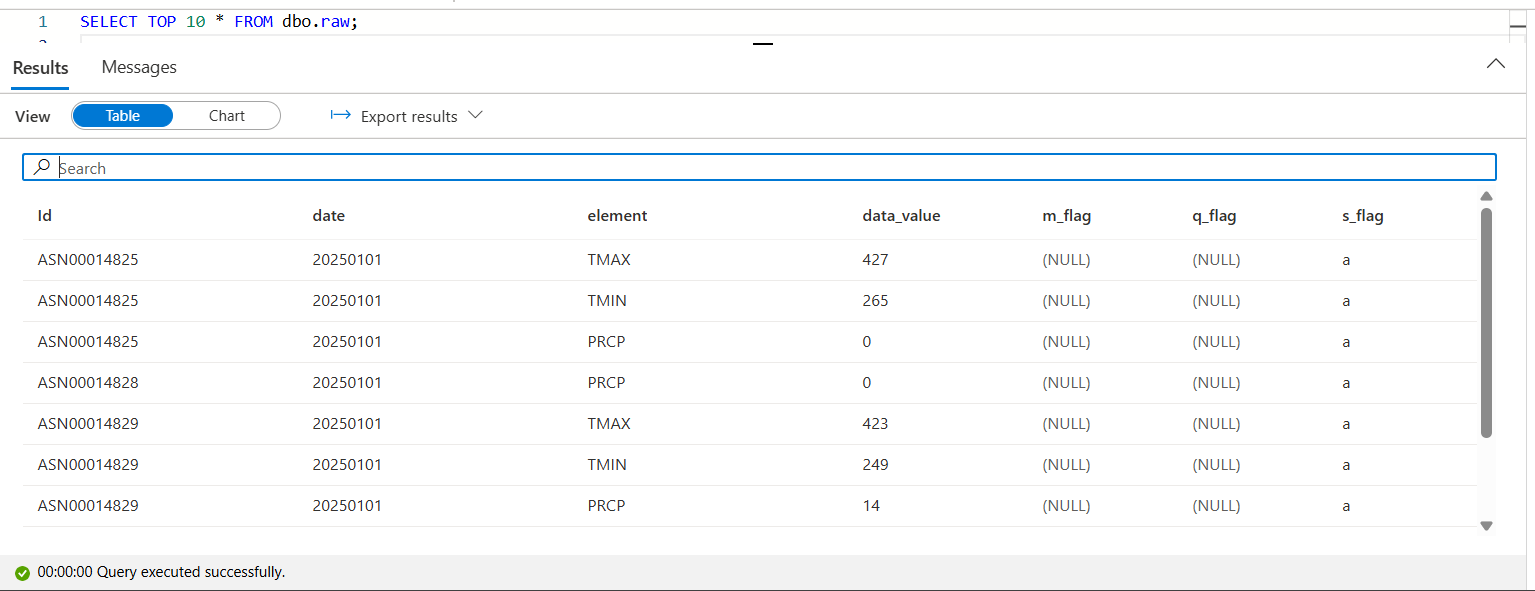

SELECT COUNT(*) FROM dbo.raw

![SELECT COUNT(*) FROM dbo.raw](<attachment:Screenshot 2025-09-26 210424.png>)
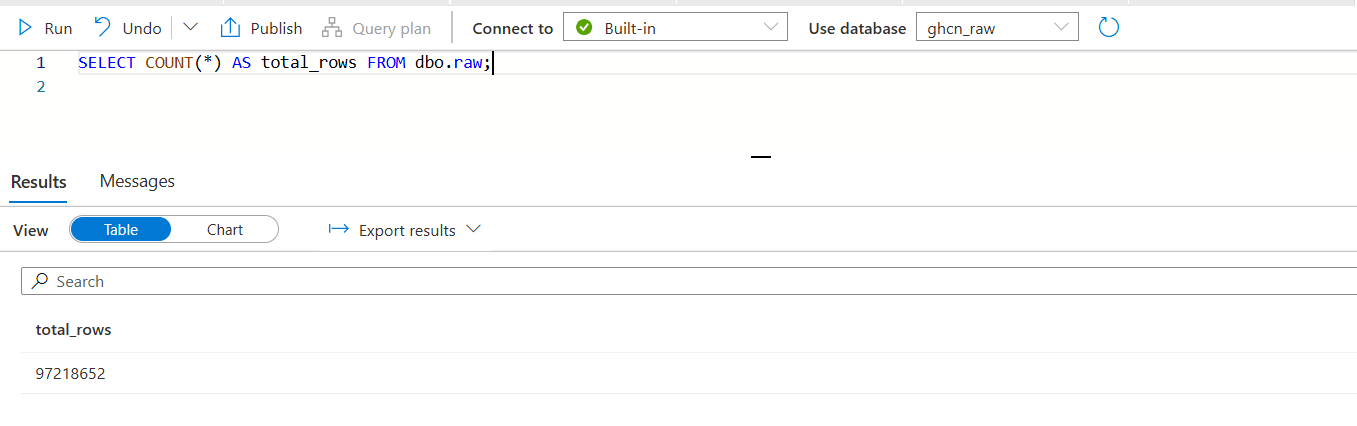

SELECT element, COUNT(*) FROM dbo.raw GROUP BY element ORDER BY COUNT(*) DESC

![Screenshot 2025-09-27 231107.png](<attachment:Screenshot 2025-09-27 231107.png>)
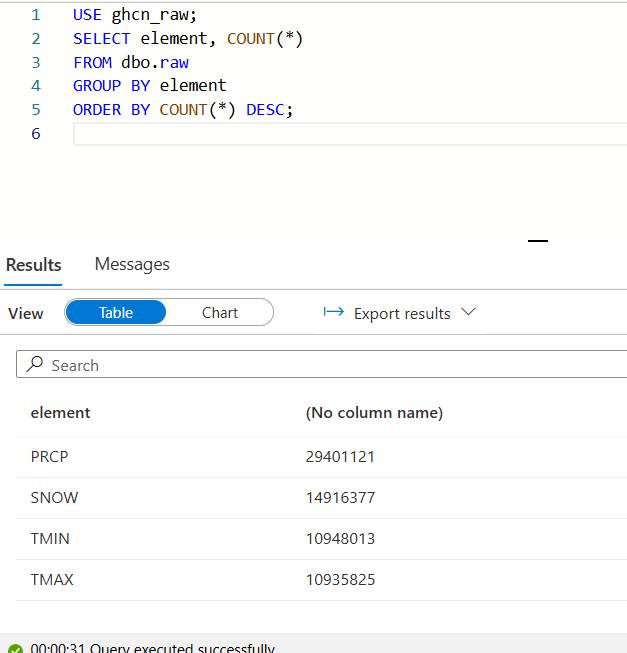

SELECT MIN([date]), MAX([date]) FROM dbo.raw

![SELECT MIN([date]), MAX([date]) FROM dbo.raw](<attachment:Screenshot 2025-09-26 210917.png>)
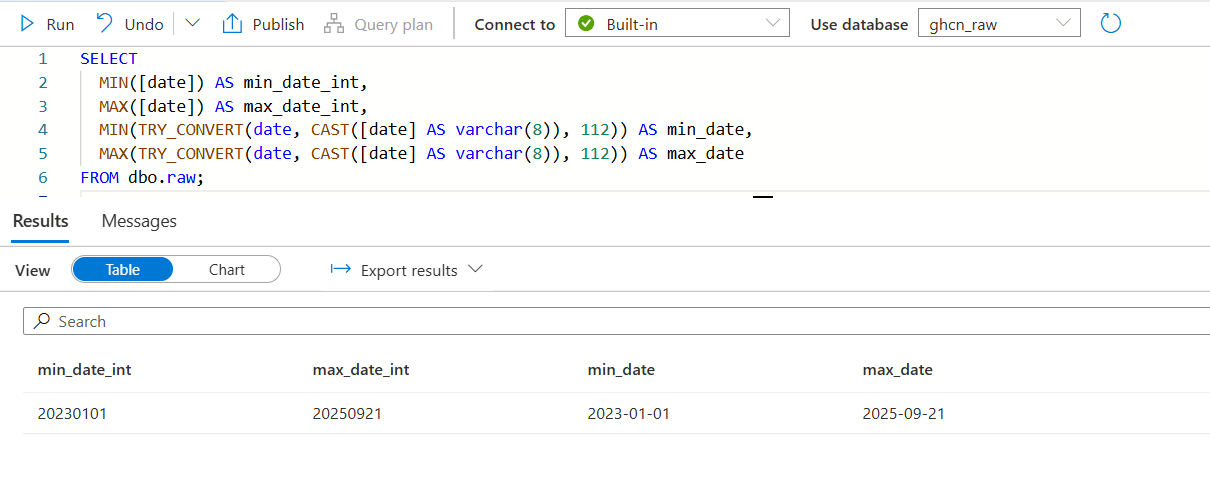

monthly TMAX (avg °C) for your first station (YYYYMM)

![Screenshot 2025-09-27 230408.png](<attachment:Screenshot 2025-09-27 230408.png>)
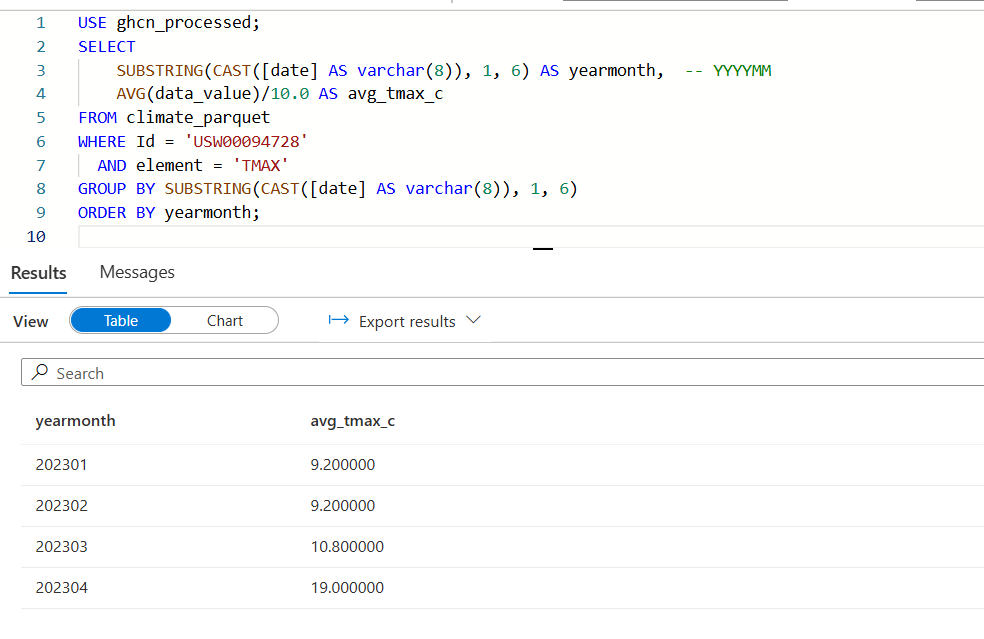

monthly PRCP (total mm) for the same station

![monthly PRCP (total mm) for the same station](<attachment:Screenshot 2025-09-26 211749.png>)
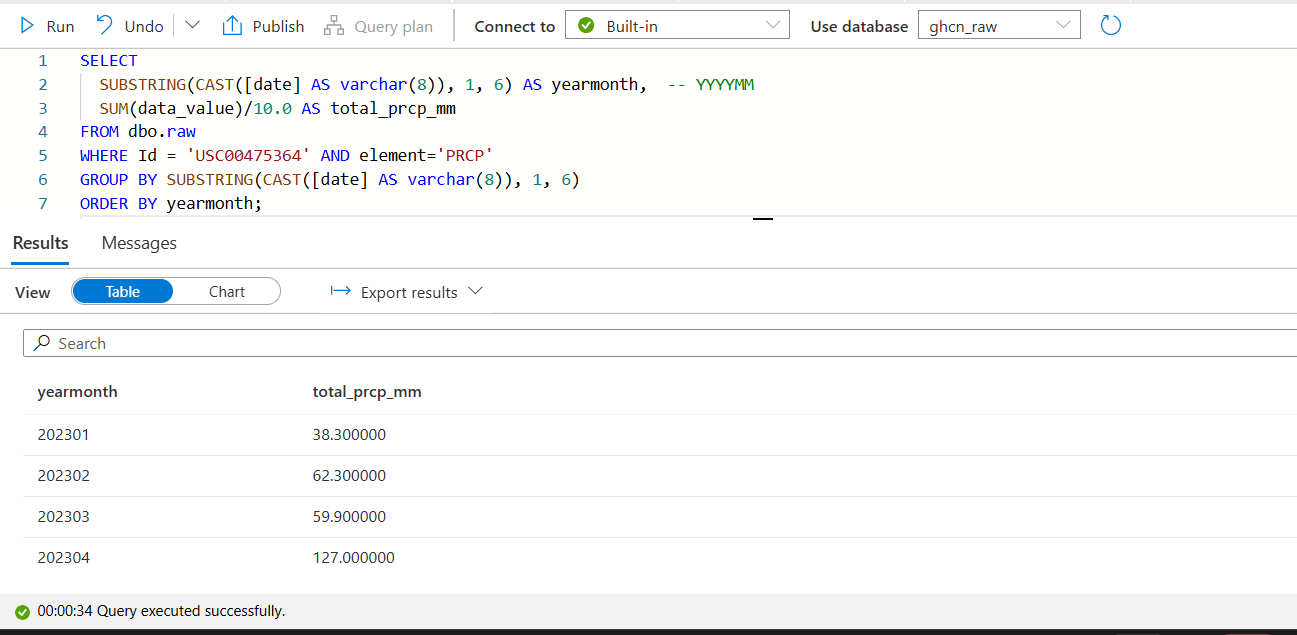

SELECT COUNT(*) FROM dbo.climate_parquet

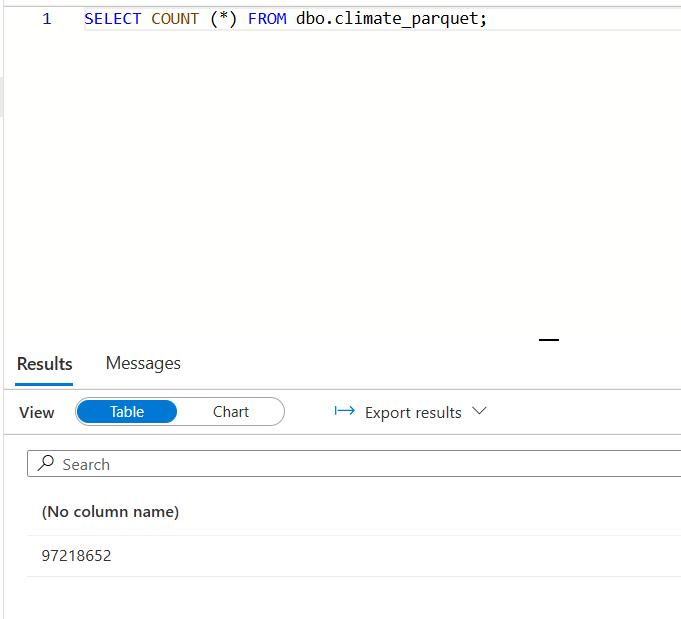

SELECT TOP 10 * FROM dbo.climate_parquet

![SELECT TOP 10 * FROM dbo.climate_parquet](<attachment:Screenshot 2025-09-26 222806.png>)
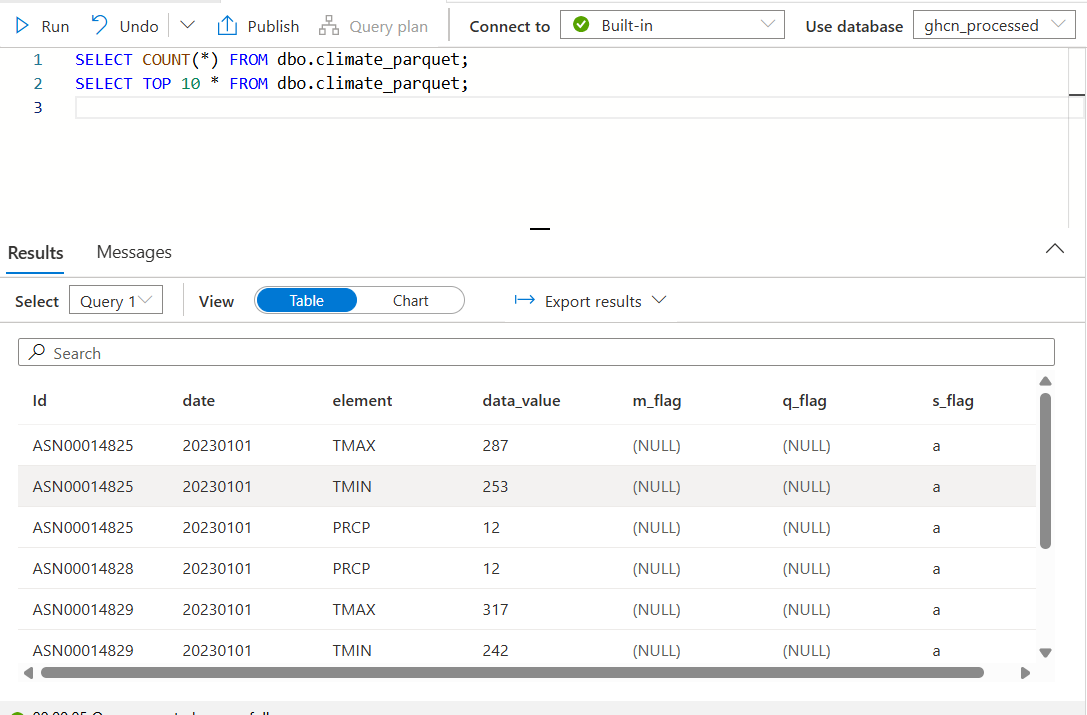

## Part 2 – Analyze Weather Station 1
### Load Precipitation Data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa

SERVER   = "syn-climate-60302363-ondemand.sql.azuresynapse.net"
DATABASE = "ghcn_processed"
USERNAME = "student_user"
PASSWORD = "StrongPassword!123"

engine = sa.create_engine(
    f"mssql+pyodbc://{USERNAME}:{PASSWORD}@{SERVER}:1433/{DATABASE}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)

with engine.connect() as conn:
    df_prcp = pd.read_sql(sa.text("""
        SELECT [date], precipitation_mm
        FROM dbo.prcp_series
        ORDER BY [date];
    """), conn)

df_prcp['date'] = pd.to_datetime(df_prcp['date'].astype(str), format='%Y%m%d', errors='coerce')
print(df_prcp.head())


### Load Temperature (TMAX) and Precipitation (PRCP) Series


In [ ]:
with engine.connect() as conn:
    tmax = pd.read_sql(sa.text("""
        SELECT [date], max_temp_c
        FROM dbo.tmax_series
        ORDER BY [date];
    """), conn)

    prcp = pd.read_sql(sa.text("""
        SELECT [date], precipitation_mm
        FROM dbo.prcp_series
        ORDER BY [date];
    """), conn)

# parse YYYYMMDD
tmax['date'] = pd.to_datetime(tmax['date'], format="%Y%m%d", errors='coerce')
prcp['date'] = pd.to_datetime(prcp['date'], format="%Y%m%d", errors='coerce')

tmax.head(), prcp.head()


### Yearly Aggregates and Year-over-Year Changes (Station 1)


In [ ]:
# --- assumes 'engine' is already defined (from your connection cell) ---

import pandas as pd
import sqlalchemy as sa

# 1) Load series (safe to re-run)
with engine.connect() as conn:
    tmax = pd.read_sql(sa.text("""
        SELECT [date], max_temp_c
        FROM dbo.tmax_series
        ORDER BY [date];
    """), conn)
    prcp = pd.read_sql(sa.text("""
        SELECT [date], precipitation_mm
        FROM dbo.prcp_series
        ORDER BY [date];
    """), conn)

# 2) Parse dates and build yearly summaries
tmax['date'] = pd.to_datetime(tmax['date'].astype(str), format="%Y%m%d", errors='coerce')
prcp['date'] = pd.to_datetime(prcp['date'].astype(str), format="%Y%m%d", errors='coerce')
tmax['year'] = tmax['date'].dt.year
prcp['year'] = prcp['date'].dt.year

yr_tmax = (
    tmax.groupby('year', as_index=False)['max_temp_c']
        .mean()
        .rename(columns={'max_temp_c': 'avg_tmax_c'})
)
yr_prcp = (
    prcp.groupby('year', as_index=False)['precipitation_mm']
        .sum()
        .rename(columns={'precipitation_mm': 'total_prcp_mm'})
)

yearly = yr_tmax.merge(yr_prcp, on='year', how='outer').sort_values('year')
display(yearly)

# 3) Year-over-year deltas (handles missing years gracefully)
def delta(df, col, y2, y1):
    v2 = df.loc[df['year'] == y2, col]
    v1 = df.loc[df['year'] == y1, col]
    return (float(v2) - float(v1)) if len(v2) == 1 and len(v1) == 1 else None

print("Δ Avg TMAX 2024-2023 (°C):",      delta(yearly, 'avg_tmax_c',    2024, 2023))
print("Δ Avg TMAX 2025-2024 (°C):",      delta(yearly, 'avg_tmax_c',    2025, 2024), "(2025 may be partial)")
print("Δ Total PRCP 2024-2023 (mm):",    delta(yearly, 'total_prcp_mm', 2024, 2023))
print("Δ Total PRCP 2025-2024 (mm):",    delta(yearly, 'total_prcp_mm', 2025, 2024), "(2025 may be partial)")


## Part 2 – Analyze Weather Station 2
### Station ID: USC00304996


In [ ]:
SECOND_ID = "USC00304996"   

with engine.connect() as conn:
    tmax2 = pd.read_sql(sa.text("""
        SELECT CAST([date] AS varchar(8)) AS date, data_value/10.0 AS max_temp_c
        FROM dbo.climate_parquet
        WHERE Id = :sid AND element='TMAX'
        ORDER BY [date];
    """), conn, params={'sid': SECOND_ID})

    prcp2 = pd.read_sql(sa.text("""
        SELECT CAST([date] AS varchar(8)) AS date, data_value/10.0 AS precipitation_mm
        FROM dbo.climate_parquet
        WHERE Id = :sid AND element='PRCP'
        ORDER BY [date];
    """), conn, params={'sid': SECOND_ID})

# parse dates
tmax2['date'] = pd.to_datetime(tmax2['date'], format="%Y%m%d", errors='coerce')
prcp2['date'] = pd.to_datetime(prcp2['date'], format="%Y%m%d", errors='coerce')

# yearly summaries
tmax2['year'] = tmax2['date'].dt.year
prcp2['year'] = prcp2['date'].dt.year
yr_tmax2 = tmax2.groupby('year', as_index=False)['max_temp_c'].mean().rename(columns={'max_temp_c':'avg_tmax_c'})
yr_prcp2 = prcp2.groupby('year', as_index=False)['precipitation_mm'].sum().rename(columns={'precipitation_mm':'total_prcp_mm'})
yearly2 = yr_tmax2.merge(yr_prcp2, on='year', how='outer').sort_values('year')
display(yearly2)

# charts
yearly2.plot(x='year', y='avg_tmax_c', kind='bar', title=f'{SECOND_ID} – Yearly Avg TMAX (°C)')
plt.show()
yearly2.plot(x='year', y='total_prcp_mm', kind='bar', title=f'{SECOND_ID} – Yearly Total Precipitation (mm)')
plt.show()

# deltas for the second station
print(f"{SECOND_ID} Δ Avg TMAX 2024-2023 (°C):",      delta(yearly2, 'avg_tmax_c',    2024, 2023))
print(f"{SECOND_ID} Δ Avg TMAX 2025-2024 (°C):",      delta(yearly2, 'avg_tmax_c',    2025, 2024), "(2025 may be partial)")
print(f"{SECOND_ID} Δ Total PRCP 2024-2023 (mm):",    delta(yearly2, 'total_prcp_mm', 2024, 2023))
print(f"{SECOND_ID} Δ Total PRCP 2025-2024 (mm):",    delta(yearly2, 'total_prcp_mm', 2025, 2024), "(2025 may be partial)")


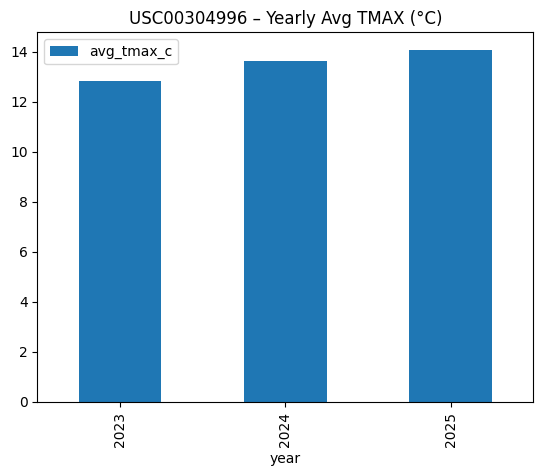

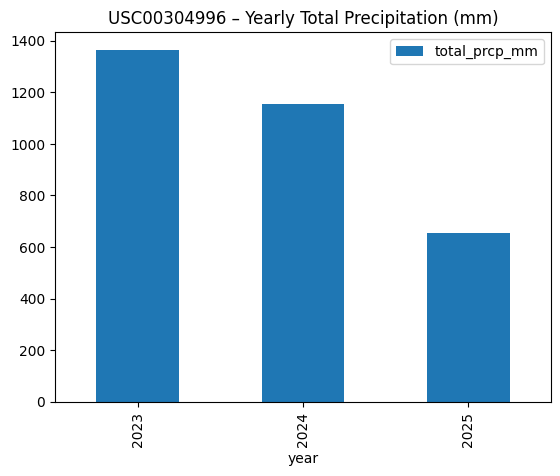

Conclusion

This lab offered me the opportunity to go through the entire process of processing raw climate data into useful and readily analysable information.
We had very large CSVs, stored in Azure Blob Storage, which were the Global Historical Climatology Network (GHCN) large CSVs. These files are large and inefficient to query directly and as such the initial step was to migrate them to a more favorable format. I have attached the raw files to Synapse Studio, and then used CETAS (Create External Table As Select) to write the data with the same format in Parquet format. It was possible to undertake the steps as parquet is much faster and lighter to scan.

After the data was ready, I linked a Jupyter notebook in Azure machine learning to the Synapse serverless SQL endpoint. There I could order only the items of interest to me: maximum temperature by the day (TMAX) and precipitation (PRCP) of certain weather stations. I converted the values per day to annual sums, found averages and totals, and made simple bar charts illustrating the change in temperature and rainfall in 2023, 2024 and 2025. Lastly, I compared the changes between years 2023 to 2024 and 2024 to 2025 in order to bring out the trends.

The stages of the ETL (Extract, Transform, Load) occurred mostly in Synapse:
Extract: Get the raw CSVs out of Blob Storage.
Transform: turning them into Parquet, and reducing it to the TMAX and PRCP series.
Load: parquet save those converted Parquet files back to Blob and parquet save as external tables into Synapse.

What followed was more of analysis and visualization: typing queries, calculating annual data and presenting the findings in tables and charts.

Concisely, the lab demonstrated the transformation of unorganized raw data to structured insights and how cloud computing applications such as Azure Synapse and Azure ML enable that pipeline to be efficient and repeatable.